# Test A Custom Tensorflow Model

# Setup

__Let's first ensure we have a 2x version of tensorflow to manage our framework calls.__

In [1]:
!pip install -U --pre tensorflow=="2.*"

     |████████████████████████████████| 515.9MB 24kB/s s eta 0:00:01    |█████▌                          | 88.6MB 63.7MB/s eta 0:00:07     |█████████████████               | 274.6MB 63.0MB/s eta 0:00:04     |█████████████████████████▉      | 415.8MB 54.3MB/s eta 0:00:02     |█████████████████████████████▉  | 480.4MB 54.5MB/s eta 0:00:01
     |████████████████████████████████| 2.9MB 31.9MB/s eta 0:00:01
     |████████████████████████████████| 3.9MB 55.3MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/dc/29/162476fd44203116e7980cfbd9352eef9db37c49445d1fec35509022f6aa/scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl
     |████████████████████████████████| 450kB 37.9MB/s eta 0:00:01
     |████████████████████████████████| 61kB 11.9MB/s eta 0:00:01
     |████████████████████████████████| 81kB 15.4MB/s eta 0:00:01
     |████████████████████████████████| 163kB 55.6MB/s eta 0:00:01
     |████████████████████████████████| 153kB 55.4MB/s eta 0:00:01
ERROR: tensorflow-serving-a

      Successfully uninstalled six-1.11.0
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0
  Found existing installation: requests 2.20.0
    Uninstalling requests-2.20.0:
      Successfully uninstalled requests-2.20.0
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0
You should consider upgrading via the 'pip install --

In [2]:
!pip install pycocotools

     |████████████████████████████████| 1.5MB 25.8MB/s eta 0:00:01
  Created wheel for pycocotools: filename=pycocotools-2.0.0-cp36-cp36m-linux_x86_64.whl size=315484 sha256=76bb5a8052ea3da8e7b28c0d890045898acd6ca5892108c59cae2d72bbecc760
  Stored in directory: /home/ec2-user/.cache/pip/wheels/dc/e6/36/0e1ae88c868eb42d3f92181b1c9bbd0b217a7ec3da6bd62e55
Successfully built pycocotools
You should consider upgrading via the 'pip install --upgrade pip' command.


### Compile protobufs and install the object_detection package

In [3]:
%%bash
cd ~/SageMaker/amazon-sagemaker-aws-greengrass-custom-object-detection-model/container/container/resources/tensorflow-models/research
protoc object_detection/protos/*.proto --python_out=.

In [4]:
%%bash 
cd ~/SageMaker/amazon-sagemaker-aws-greengrass-custom-object-detection-model/container/container/resources/tensorflow-models/research
pip3 install .

Processing /home/ec2-user/SageMaker/amazon-sagemaker-aws-greengrass-custom-object-detection-model/container/container/resources/tensorflow-models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=997085 sha256=ef05df55f894df1ca63af8fd765c9b8d684f75a210dad7e5302d0656d06b96d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-2m1iipel/wheels/40/ed/41/69c5653975c81455248e69d4dc01090a77ed135055b568ce20
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


You should consider upgrading via the 'pip install --upgrade pip' command.


### Import necessary libraries

In [5]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display


### Import the object detection module.

In [7]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

### Apply Patches:

In [8]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

### Helper Functions:

In [9]:
def make_tmp_folder(folder_name):
    try:
        os.makedirs(folder_name, exist_ok=False)
    except FileExistsError:
        print("{} folder already exists".format(folder_name))           
        
def load_model(model_dir):
    
    model_dir = pathlib.Path(model_dir)/"saved_model"
    model = tf.saved_model.load(str(model_dir))
    model = model.signatures['serving_default']

    return model

## Download Model

Set model variable to the s3 location of best training job in the Sagemaker training console otherwise set the location to the output location of the single training run (e.g. - s3://{BUCKET}/output-model/tensorflow-detection-xxxxx)


In [ ]:
BUCKET = 'cvml-sagemaker-repo'
TMP_FOLDER_NAME = 'tmp'

#Tip: you can copy the model location from the best training job in the Sagemaker console
MODEL_LOCATION = 's3://cvml-sagemaker-repo/output-model/tensorflow-detection-200318-1922-001-966b844b/output/model.tar.gz'

#create the temp dir for all assets
make_tmp_folder(TMP_FOLDER_NAME)

#Download the model
!aws s3 cp $MODEL_LOCATION $TMP_FOLDER_NAME

#unzip the model
!tar -xvzf $TMP_FOLDER_NAME/model.tar.gz -C $TMP_FOLDER_NAME/

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [10]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '{}/graph/label_map.pbtxt'.format(TMP_FOLDER_NAME)
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=False)

## Download Test images from S3
Set the directory below with which to test your model against (keep collection small to avoid longer response times):

In [18]:
#S3 folder containing images that you wish to test against your model
S3_IMAGE_LOCATION = 's3://cvml-sagemaker-repo/validation-images/'

#location that will be created locally for storage
LOCAL_IMAGE_DIR = '{}/validation-images'.format(TMP_FOLDER_NAME)

make_tmp_folder(LOCAL_IMAGE_DIR)

#download images
!aws s3 cp $S3_IMAGE_LOCATION $LOCAL_IMAGE_DIR --recursive

PATH_TO_VALIDATION_DIR = pathlib.Path(LOCAL_IMAGE_DIR)
TEST_IMAGE_PATHS = sorted(list(PATH_TO_VALIDATION_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

tmp/validation-images folder already exists
download: s3://cvml-sagemaker-repo/validation-images/wake_test2.jpg to tmp/validation-images/wake_test2.jpg
download: s3://cvml-sagemaker-repo/validation-images/wake_test.jpg to tmp/validation-images/wake_test.jpg


[PosixPath('tmp/validation-images/wake_test.jpg'),
 PosixPath('tmp/validation-images/wake_test2.jpg')]

# Detection

Load an object detection model:

In [11]:
#MODEL_LOCATION = '{}/graph/'.format(TMP_FOLDER_NAME)
MODEL_LOCATION = 'tmp/graph'
detection_model = load_model(MODEL_LOCATION)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Check the model's input signature, it expects a batch of 3-color images of type uint8: 

In [12]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


And retuns several outputs:

In [13]:
detection_model.output_dtypes

{'detection_classes': tf.float32,
 'num_detections': tf.float32,
 'detection_boxes': tf.float32,
 'raw_detection_boxes': tf.float32,
 'detection_scores': tf.float32,
 'raw_detection_scores': tf.float32,
 'detection_multiclass_scores': tf.float32}

In [14]:
detection_model.output_shapes

{'detection_classes': TensorShape([None, 100]),
 'num_detections': TensorShape([None]),
 'detection_boxes': TensorShape([None, 100, 4]),
 'raw_detection_boxes': TensorShape([None, None, 4]),
 'detection_scores': TensorShape([None, 100]),
 'raw_detection_scores': TensorShape([None, None, 2]),
 'detection_multiclass_scores': TensorShape([None, 100, 2])}

Add a wrapper function to call the model, and cleanup the outputs:

In [15]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)
  
  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results. <br>
Note the *min_score* argument to manage your confidence threshold.

In [16]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8, min_score_thresh=.1)

  display(Image.fromarray(image_np))

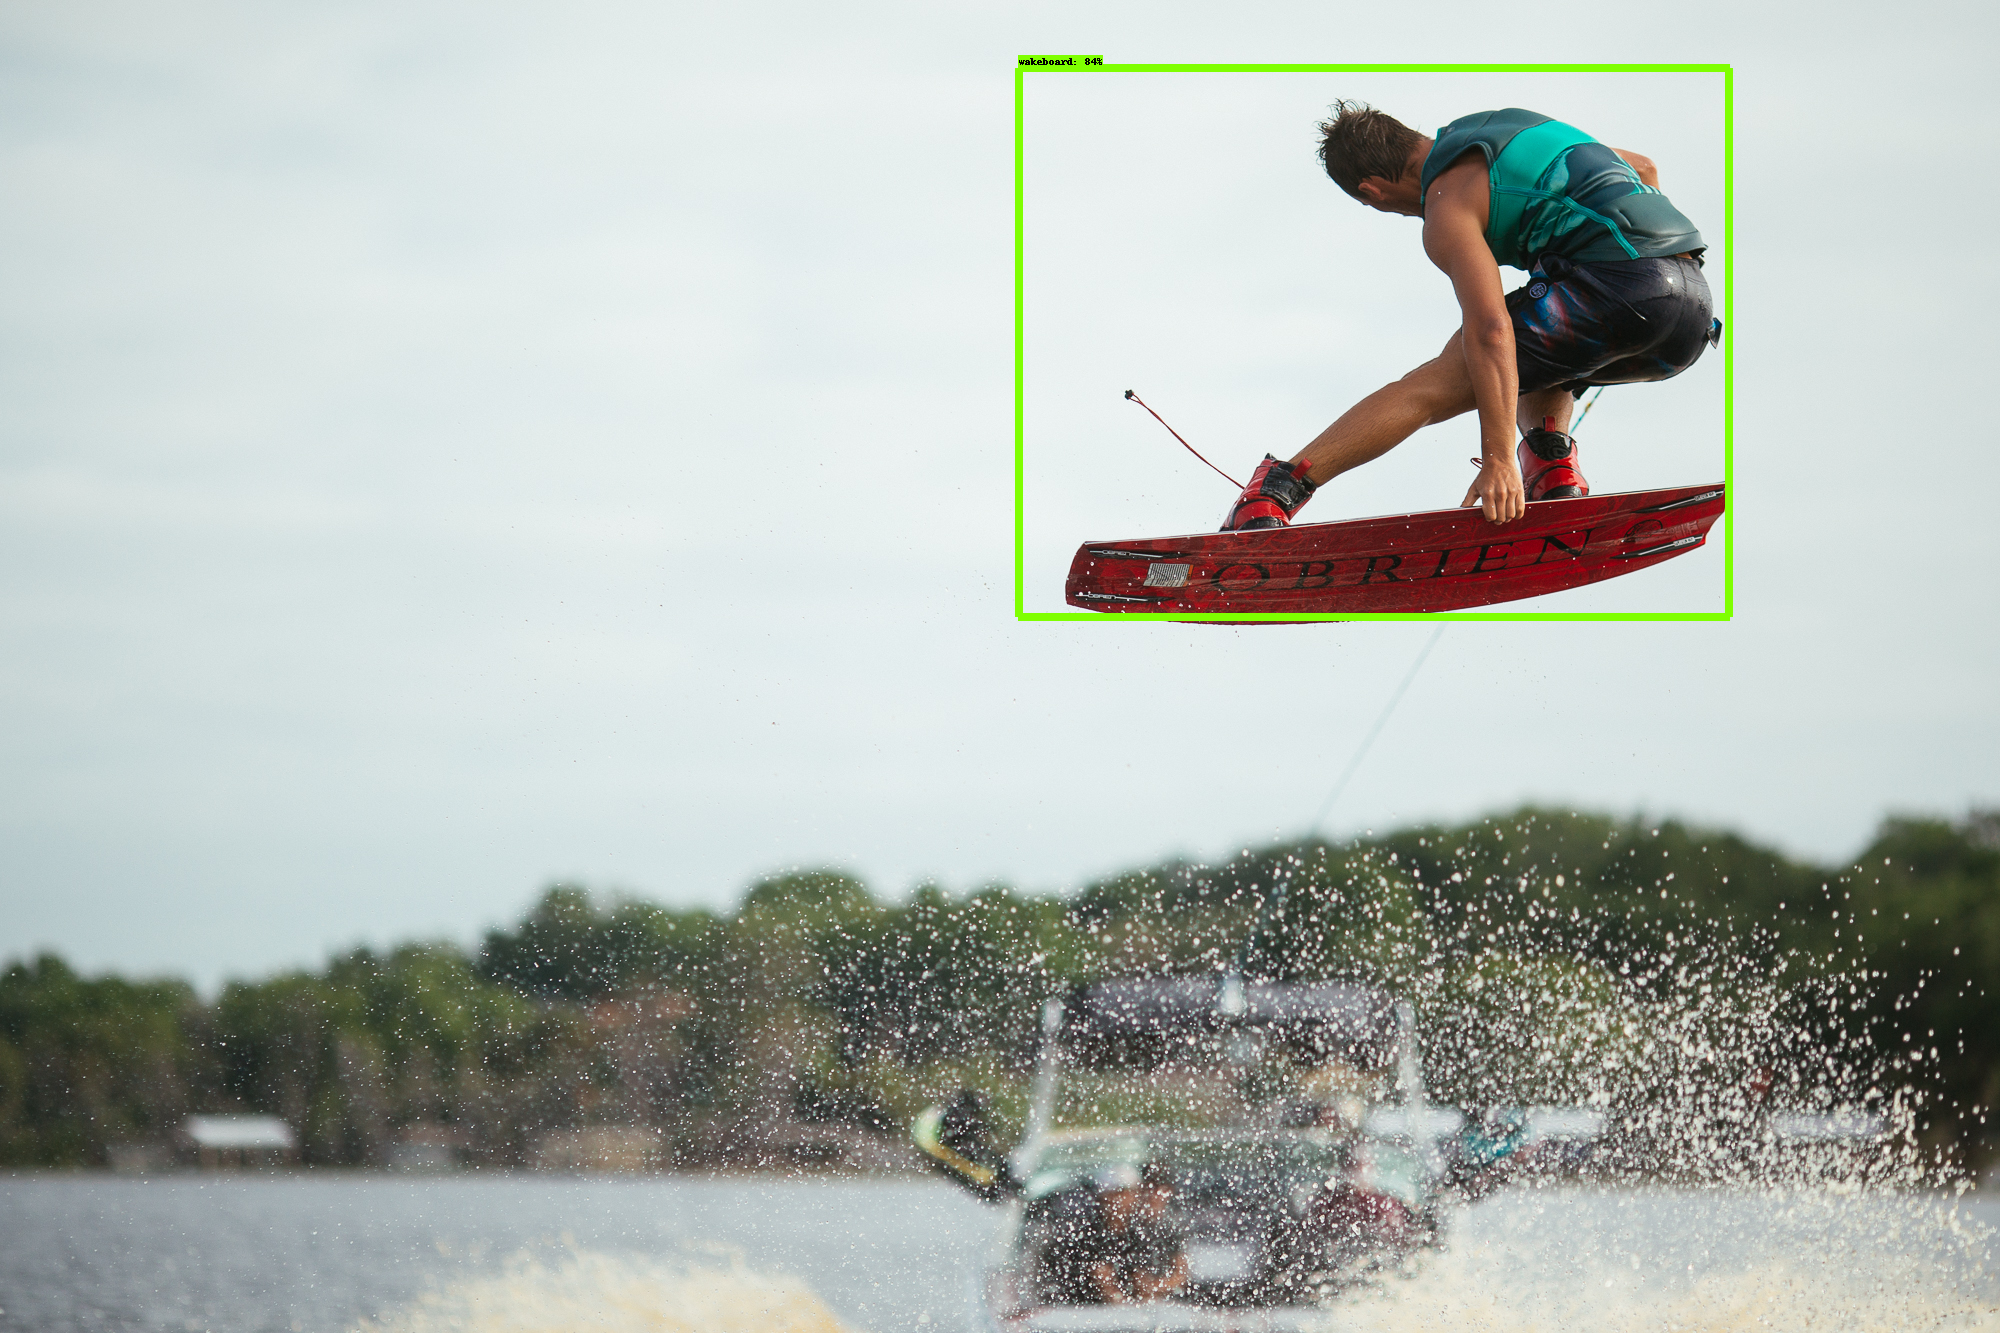

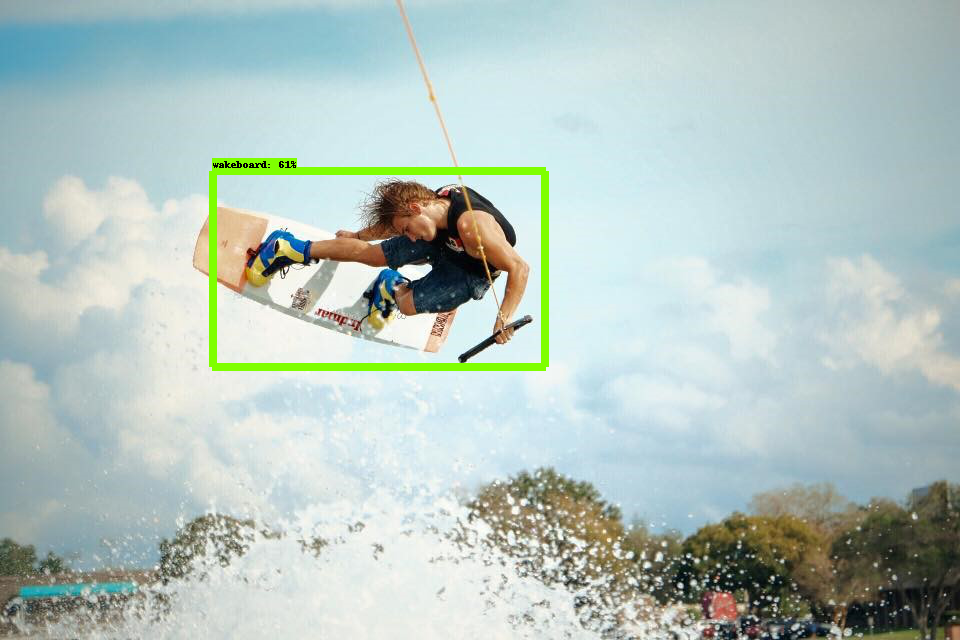

In [19]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)


### Pretty cool, huh?!
At this point, I will include 2 more notebooks. One to explain how to retrain the model with additional data if you do not like the results at this sage. The second notebook will explain how to take an acceptible model and use it in our CV/ML python framework. 